In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

project_root = os.path.abspath(r".") 
if project_root not in sys.path:
    sys.path.append(project_root)

from functions.temporal_schemes import integrate, rk4_step


print("Milestone 5 Modules Loaded.")

Milestone 5 Modules Loaded.


In [2]:
def F_nbody(u, t, masses, G=1.0, epsilon=1e-12):
    """
    Computes derivatives for the N-body problem.
    
    Args:
        u: State vector [r1...rN, v1...vN] (positions flattened, then velocities flattened)
        masses: List of masses
    """
    N = len(masses)
    dims = 3 
    
    # The state vector u has length 2 * N * 3
    # First half is positions, second half is velocities
    mid = N * dims
    r_flat = u[:mid]
    v_flat = u[mid:]
    
    # Reshape positions to (N, 3) for vector math
    rs = r_flat.reshape((N, dims))
    
    # Initialize accelerations
    acc = np.zeros_like(rs)
    
    # Compute forces
    for i in range(N):
        for j in range(N):
            if i != j:
                rij = rs[j] - rs[i]  # Vector from i to j
                dist = np.linalg.norm(rij)
                # F = G * m * M / r^3 * vec_r
                # Softening epsilon to avoid division by zero 
                acc[i] += G * masses[j] * rij / ((dist**2 + epsilon**2)**1.5)
                
    # Return derivative: [velocities, accelerations]
    return np.concatenate([v_flat, acc.flatten()])

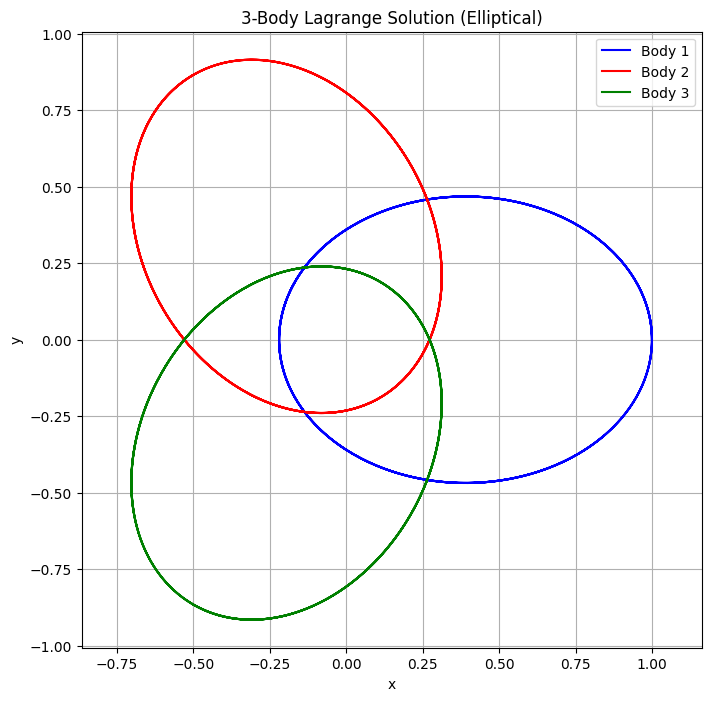

In [3]:
# 1. Setup parameters for the Lagrange Triangle (Elliptical Case) for testing
m = 1.0
masses = np.array([m, m, m])
G = 1.0

# Distance from center of mass
R = 1.0

# Calculate velocity for a perfect circle
v_circ = np.sqrt(G * m / (np.sqrt(3) * R))

#velocity scaling to simulate eccentric orbit behavior and compare to Lagrange solution
v_scale = 0.6  
v_mag = v_circ * v_scale

# --- Initial Positions (Equilateral Triangle) ---
# Angles: 0, 120, 240 degrees
ang1 = 0
ang2 = 2 * np.pi / 3
ang3 = 4 * np.pi / 3

r1 = np.array([R * np.cos(ang1), R * np.sin(ang1), 0])
r2 = np.array([R * np.cos(ang2), R * np.sin(ang2), 0])
r3 = np.array([R * np.cos(ang3), R * np.sin(ang3), 0])

# --- Initial Velocities (Tangential) ---
v1 = np.array([-v_mag * np.sin(ang1), v_mag * np.cos(ang1), 0])
v2 = np.array([-v_mag * np.sin(ang2), v_mag * np.cos(ang2), 0])
v3 = np.array([-v_mag * np.sin(ang3), v_mag * np.cos(ang3), 0])

# Construct state vector
u0_tri_ellip = np.concatenate([r1, r2, r3, v1, v2, v3])

# Time settings
t_start = 0
t_end = 15
dt = 0.01 

# 2. Integrate
nbody_args = {'masses': masses, 'G': G}
traj_ellip, t_val_ellip = integrate(rk4_step, u0_tri_ellip, t_start, t_end, F_nbody, dt, **nbody_args)

# 3. Plotting
plt.figure(figsize=(8, 8))

# Trajectories
plt.plot(traj_ellip[:, 0], traj_ellip[:, 1], label='Body 1', color='blue')
plt.plot(traj_ellip[:, 3], traj_ellip[:, 4], label='Body 2', color='red')
plt.plot(traj_ellip[:, 6], traj_ellip[:, 7], label='Body 3', color='green')



plt.title(f"3-Body Lagrange Solution (Elliptical)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

# Discusssion of 3-body Elliptical Lagrange Solution
To validate the $N$-body numerical integrator, the simulation was tested against the known Lagrangian Equilateral Triangle solution. While the classic Lagrange solution assumes circular orbits, this simulation generalized the problem to elliptical trajectories to test the integrator's handling of varying velocities and distances. The system was initialized with three equal masses ($m=1.0$) at the vertices of an equilateral triangle. To generate the elliptical behavior, the initial velocity was set to a scaled fraction of the circular velocity ($v_{init} = 0.6 \times v_{circ}$). Because the velocity was initialized tangentially, the starting positions ($R=1.0$) act as the apocenter for each body. This also provides the setup for Milestone 6 where this simulation will be done with further refinement and analysis.

The resulting plot (Figure 1) confirms the accuracy of the integration:

Conservation of Symmetry: The trajectories maintain 3-fold rotational symmetry throughout the simulation, forming a "pulsating" equilateral triangle.

Orbital Dynamics: The bodies correctly travel inward from the start (due to the sub-circular velocity), accelerate toward the pericenter (closest approach), and return to the apocenter, creating a 'rosette' pattern centered on the origin $(0,0)$.

Stability: The use of the RK4 integrator with $dt=0.01$ proved sufficient to maintain the closed-loop nature of the orbits over the simulated time ($t=15$), with no visible numerical drift or precession.
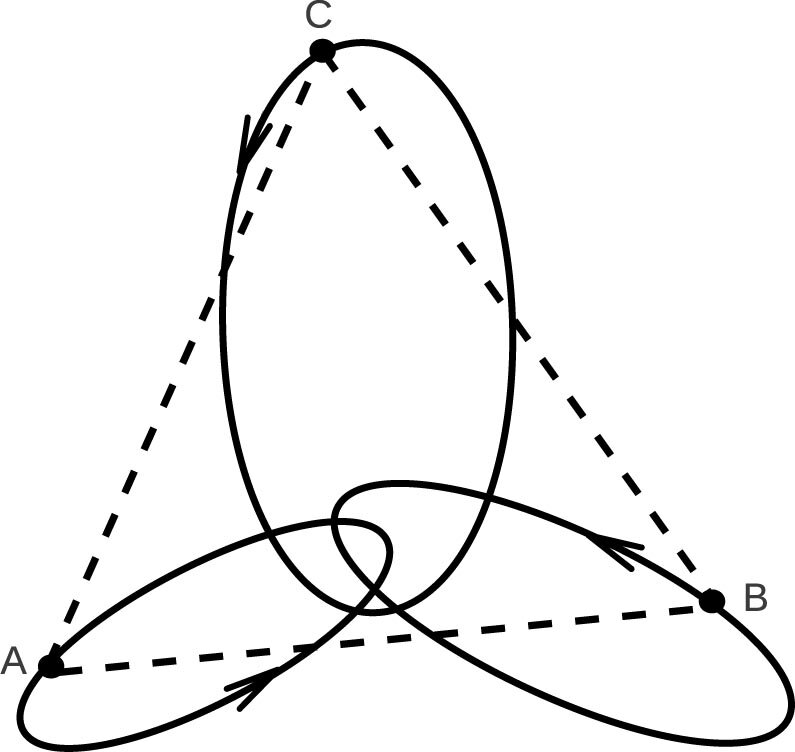

# For Fun
## Modeling Inner Solar System

To further evaluate the function, the inner solar system was modeled using parameters found on NASA's planetary data sheet. Then for fun, Mercury was replaced by a red dwarf start to see an interesting case that will definitely show if the function is working appropriately.

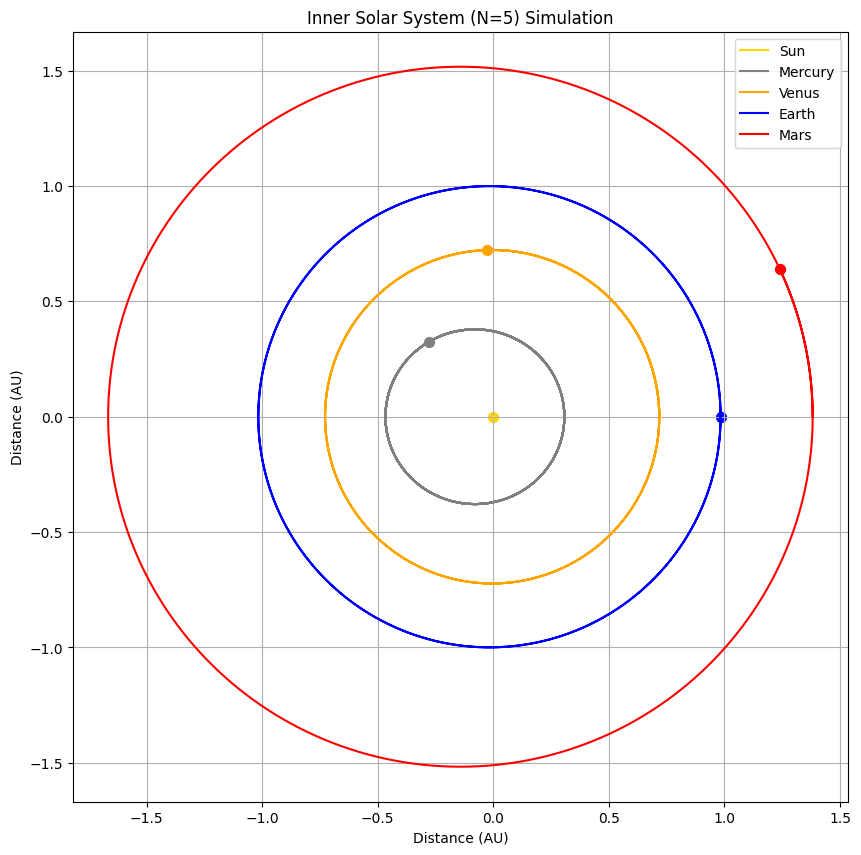

In [26]:
# 1. Define Parameters (Units: Solar Mass, AU, Year)
G = 4 * np.pi**2

# Masses (relative to Sun)
# Sun, Mercury, Venus, Earth, Mars
masses = np.array([
    1.0,                # Sun
    1.6601e-7,          # Mercury
    2.4478e-6,          # Venus
    3.0035e-6,          # Earth
    3.2271e-7           # Mars
])

names = ["Sun", "Mercury", "Venus", "Earth", "Mars"]
colors = ["gold", "gray", "orange", "blue", "red"]

# 2. Initial Conditions (Approximate Perihelion positions)
# start planets at their closest point to the Sun (perihelion) on the x-axis.
# Velocity is strictly tangential (y-direction) at this point.

# Orbital elements (Semi-major axis 'a' in AU, Eccentricity 'e')
# Data from NASA planetary fact sheet
orbits = [
    {'a': 0.0,   'e': 0.0},    # Sun (Static center initially)
    {'a': 0.387, 'e': 0.2056}, # Mercury
    {'a': 0.723, 'e': 0.0068}, # Venus
    {'a': 1.000, 'e': 0.0167}, # Earth
    {'a': 1.524, 'e': 0.0934}  # Mars
]

positions = []
velocities = []

for body in orbits:
    a = body['a']
    e = body['e']
    
    if a == 0: # Sun
        positions.append([0, 0, 0])
        velocities.append([0, 0, 0])
        continue
        
    # Perihelion distance: r_p = a * (1 - e)
    r_p = a * (1 - e)
    
    # Velocity at perihelion (Vis-viva equation)
    # v_p = sqrt( G * M_sun * ( (1+e) / (a*(1-e)) ) )
    v_p = np.sqrt( G * 1.0 * (1 + e) / r_p )
    
    # Append (x, y, z) and (vx, vy, vz)
    positions.append([r_p, 0, 0])
    velocities.append([0, v_p, 0])

# Flatten into state vector
u0_solar = np.concatenate([np.array(positions).flatten(), np.array(velocities).flatten()])

# 3. Integrate
t_start = 0
t_end = 2.0  # 2 Earth years (1 Mars orbit)
dt = 0.001   # Small step needed for Mercury's speed

# Update the physics function to use G defined in solar masses
nbody_args = {'masses': masses, 'G': G}

# Using RK4
traj_solar, t_solar = integrate(rk4_step, u0_solar, t_start, t_end, F_nbody, dt, **nbody_args)

# 4. Plotting
plt.figure(figsize=(10, 10))

# Indices for each body (x, y are 0,1 for body 1; 3,4 for body 2, etc.)
for i in range(len(masses)):
    ix = i * 3
    iy = i * 3 + 1
    
    plt.plot(traj_solar[:, ix], traj_solar[:, iy], label=names[i], color=colors[i])
    
    plt.scatter(traj_solar[-1, ix], traj_solar[-1, iy], color=colors[i], s=50)

plt.title("Inner Solar System (N=5) Simulation")
plt.xlabel("Distance (AU)")
plt.ylabel("Distance (AU)")
plt.legend(loc='upper right')
plt.grid(True)
plt.axis('equal')
plt.show()

## Inner Solar System but Mercury is a red dwarf

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


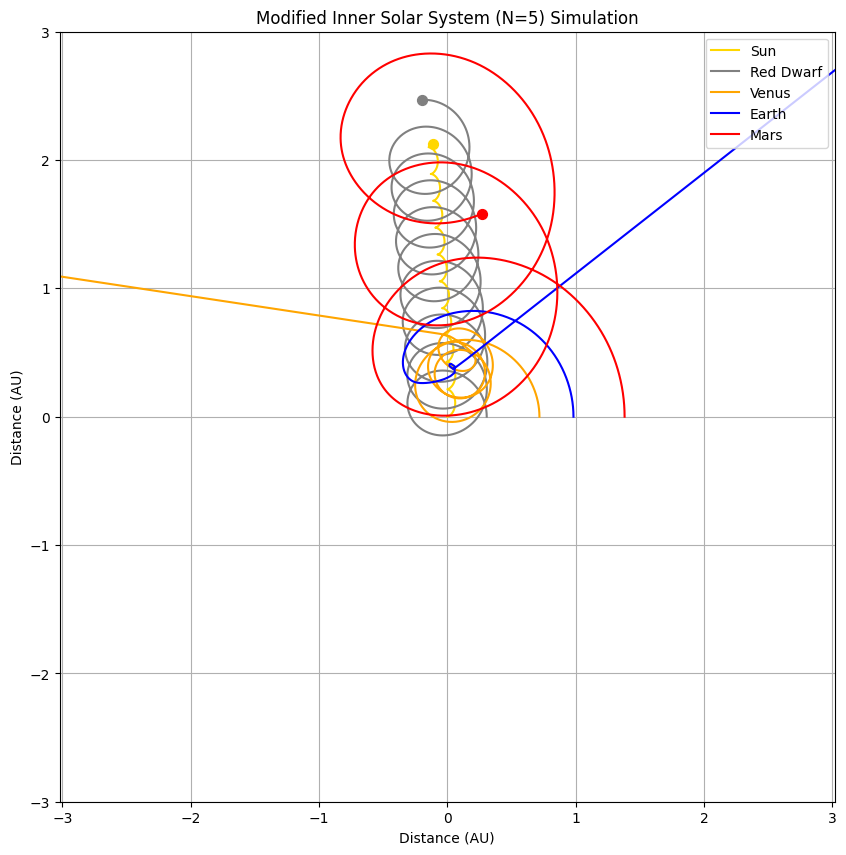

In [12]:
# 1. Define Parameters (Units: Solar Mass, AU, Year)
G = 4 * np.pi**2

# Masses (relative to Sun)
# Sun, Mercury, Venus, Earth, Mars
masses = np.array([
    1.0,                # Sun
    0.1,          # Additional lower mass star to evaluate binary star system
    2.4478e-6,          # Venus
    0.000954588,          # Earth
    3.2271e-7           # Mars
])

names = ["Sun", "Red Dwarf", "Venus", "Earth", "Mars"]
colors = ["gold", "gray", "orange", "blue", "red"]

# 2. Initial Conditions (Approximate Perihelion positions)
# Start planets at their closest point to the Sun (perihelion) on the x-axis.
# Velocity is strictly tangential (y-direction) at this point.

# Orbital elements (Semi-major axis 'a' in AU, Eccentricity 'e')
# Data from NASA planetary fact sheet
orbits = [
    {'a': 0.0,   'e': 0.0},    # Sun (Static center initially)
    {'a': 0.387, 'e': 0.2056}, # Place lower mass star at Mercury's orbit
    {'a': 0.723, 'e': 0.0068}, # Venus
    {'a': 1.000, 'e': 0.0167}, # Earth
    {'a': 1.524, 'e': 0.0934}  # Mars
]

positions = []
velocities = []

for body in orbits:
    a = body['a']
    e = body['e']
    
    if a == 0: # Sun
        positions.append([0, 0, 0])
        velocities.append([0, 0, 0])
        continue
        
    # Perihelion distance: r_p = a * (1 - e)
    r_p = a * (1 - e)
    
    # Velocity at perihelion (Vis-viva equation)
    # v_p = sqrt( G * M_sun * ( (1+e) / (a*(1-e)) ) )
    v_p = np.sqrt( G * 1.0 * (1 + e) / r_p )
    
    # Append (x, y, z) and (vx, vy, vz)
    positions.append([r_p, 0, 0])
    velocities.append([0, v_p, 0])

# Flatten into state vector
u0_solar = np.concatenate([np.array(positions).flatten(), np.array(velocities).flatten()])

# 3. Integrate
t_start = 0
t_end = 2  # 2 Earth years (enough for Mars to orbit once)
dt = 0.001   # Small step needed to see full behavior

# Update the physics function to use G defined in solar masses
nbody_args = {'masses': masses, 'G': G}

# Using RK4
traj_solar, t_solar = integrate(rk4_step, u0_solar, t_start, t_end, F_nbody, dt, **nbody_args)

# 4. Plotting
plt.figure(figsize=(10, 10))

# Indices for each body
for i in range(len(masses)):
    ix = i * 3
    iy = i * 3 + 1
    
    plt.plot(traj_solar[:, ix], traj_solar[:, iy], label=names[i], color=colors[i])
    plt.scatter(traj_solar[-1, ix], traj_solar[-1, iy], color=colors[i], s=50)

plt.title("Modified Inner Solar System (N=5) Simulation")
plt.xlabel("Distance (AU)")
plt.ylabel("Distance (AU)")
plt.legend(loc='upper right')
plt.grid(True)

# 1. Set the Aspect Ratio
plt.axis('equal') 

view_limit = 3.0 #AU
plt.xlim(-view_limit, view_limit)
plt.ylim(-view_limit, view_limit)

plt.show()